# Synthetic data TG 
This notebook uses the code that Ethan wrote to try to invert for the taylor-goldstein equation with synthetic data

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from scipy.optimize import ridder
import numpy as np
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary
from DTS_to_displacement import DTS_to_disp, get_coefs

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

## Internal wave eigenproblem for $U(z)=0$

$$W_n'' + k_n^2 \frac{N^2(z)-\omega^2}{\omega^2-f^2}W_n = 0$$

$$\rightarrow \frac{d\mathbf{y}}{dz} = \begin{bmatrix} 0 & -k^2 \frac{N^2(z)-\omega^2}{\omega^2-f^2} \\ 1 & 0 \end{bmatrix} \mathbf{y} \qquad\text{where}\qquad \mathbf{y} = \begin{bmatrix} \frac{dW}{dz} \\ W \end{bmatrix}$$

In [2]:
def dydz(y,zi,k,w,z,N,f):
    N_ = np.interp(zi,z,N)
    A = np.array([[0,-k**2 * (N_**2-w**2)/(w**2-f**2)],[1,0]])
    return A @ y

def integrate(k,y0,w,z,N,f):
    # calculates y = [dW/dz,W]
    y = odeint(dydz,y0,z,args=((k,w,z,N,f)))
    return y

def evaluate(k,w,z,N,f):
    # returns only the value W(z=H)
    y0 = [1,0]
    y = integrate(k,y0,w,z,N,f)[-1,:]
    return y[1]

def dispersion(cmin,cmax,nc,w,z,N,f,all_modes=False,num_modes=10):
    y0 = np.array([1,0])
    cs = np.logspace(np.log10(cmin),np.log10(cmax),nc)
    ys = np.zeros(nc)
    for ic,c in enumerate(cs):
        k_ = w/c
        ys[ic] = evaluate(k_,w,z,N,f)
    diff = np.diff(np.sign(ys))
    brac = np.argwhere(abs(diff)>1).flatten()
    nb = np.minimum(len(brac),num_modes)
    nnb = len(brac)
    if all_modes:
        cp = []
        for ib in range(nb):
            a = w/cs[brac[nnb-ib-1]+1]
            b = w/cs[brac[nnb-ib-1]]
            k = ridder(evaluate,a,b,(w,z,N,f))
            cp.append(w/k)
    elif len(brac)>0:
        a = w/cs[brac[-1]+1]
        b = w/cs[brac[-1]]
        k = ridder(evaluate,a,b,(w,z,N,f))
        cp = w/k
    else:
        cp = np.nan
    return cp


### Case of uniform stratification ($N=const$):

$$k_n = \pm \frac{n\pi}{H} \left(\frac{\omega^2-f^2}{N^2-\omega^2}\right)^{1/2}$$
$$W_n = \sin{\left(\frac{n\pi z}{H}\right)}$$

In [3]:
## Parameters
nz = 20                      # num points to evaluate eigenfunction
H = 100                      # water depth (m)
z = np.linspace(0,H,nz)      # depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
N = 1e-2*np.ones(nz)         # buoyancy frequency (rad/s)
nw = 20
ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest

## Compute dispersion
cmin = 0.01 # m/s
cmax = 10
nc = 100
all_modes = True

nn = 3 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes,num_modes=3)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

In [4]:
## Analytical solution
cn = np.zeros((nw,nn))
Wn = np.zeros((nw,nz,nn))
for n in range(nn):
    cn[:,n] = ws/((np.pi*(n+1)/H)*np.sqrt((ws**2-f**2)/(N[0]**2-ws**2)))
    Wn[:,:,n] = np.sin((n+1)*np.pi*z/H)

Text(0, 0.5, 'Depth (m)')

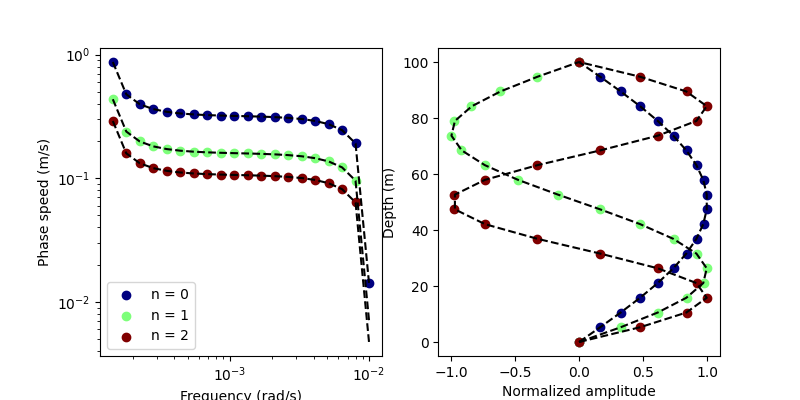

In [5]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,2,figsize=(8,4))
for n in range(nn):
    ax[0].plot(ws,cn[:,n],'k--')
    ax[0].scatter(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='lower left')

for n in range(nn):
    ax[1].plot(Wn[0,:,n],z,'k--')
    ax[1].scatter(W[0,:,n]/max(abs(W[0,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')

### Layered stratification

In [6]:
## Parameters
nz = 50                      # num points to evaluate eigenfunction
H = 100                      # water depth (m)
z = np.linspace(0,H,nz)      # depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
N = np.ones(nz)*1e-2              # buoyancy frequency (rad/s)
H0 = H//2
N[np.logical_and(z>=H0//4,z<=H0//2)] = 2e-2
N[np.logical_and(z>=H0//2,z<=3*H0//4)] = 1e-2
N[z>=3*H//4] = 2e-2
nw = 10
ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest

## Compute dispersion
cmin = 0.1 # m/s
cmax = 5
nc = 80
all_modes = True

nn = 3 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

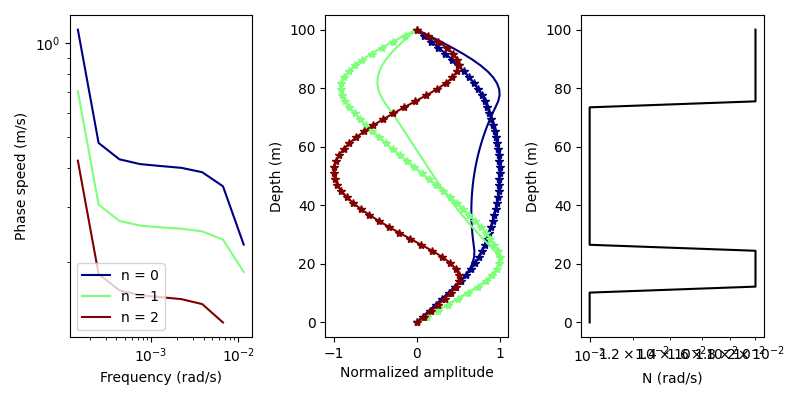

In [7]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,3,figsize=(8,4))
for n in range(nn):
    #ax[0].plot(ws,cn[:,n],'k--')
    ax[0].plot(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend(loc='lower left')

for n in range(nn):
    #ax[1].plot(Wn[0,:,n],z,'k--')
    ax[1].plot(W[0,:,n]/max(abs(W[0,:,n])),z,color=colors[n],marker='*')
    ax[1].plot(W[-2,:,n]/max(abs(W[-2,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')

ax[2].plot(N,z,'k')
ax[2].set_xlabel('N (rad/s)')
ax[2].set_ylabel('Depth (m)')
ax[2].set_xscale('log')

plt.tight_layout()

### Greenfjord N-profile

In [8]:
tmp = np.genfromtxt('../data/synthetic-data/Depth_Temp_N.csv',delimiter=',',skip_header=2)
z = tmp[:,0]
N = np.convolve(tmp[:,1],np.ones(10)/10,mode='same')
T = np.convolve(tmp[:,2],np.ones(10)/10,mode='same')

In [9]:
## Parameters
nz = len(z)                  # num points to evaluate eigenfunction
H = max(z)                   # water depth (m)
f = 2*np.pi/(13*60*60)       # inertial frequency (rad/s)
#nw = 15
#ws = np.logspace(np.log10(f+1e-5),np.log10(max(N)-1e-5),nw) # frequencies of interest
ws = np.array([2*np.pi/(12*60*60),2*np.pi/(15*60)])
nw = len(ws)

## Compute dispersion
cmin = 0.05 # m/s
cmax = 2
nc = 100
all_modes = True

nn = 10 # number of modes to save
c = np.zeros((nw,nn))*np.nan
W = np.zeros((nw,nz,nn))*np.nan
for i, w in enumerate(ws):
    print(i+1,nw)
    tmp = dispersion(cmin,cmax,nc,w,z,N,f,all_modes,num_modes=nn)
    for j in range(np.minimum(nn,len(tmp))):
        c[i,j] = tmp[j]
        W[i,:,j] = integrate(w/c[i,j],[1,0],w,z,N,f)[:,1]

1 2
2 2


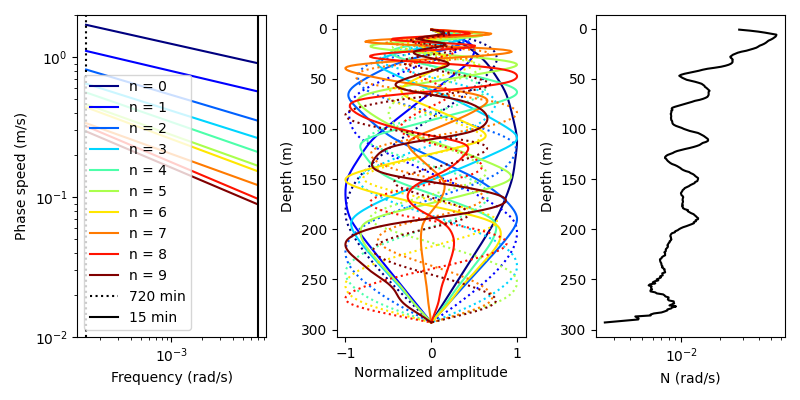

In [10]:
## Plotting
colors = plt.cm.jet(np.linspace(0,1,nn))
fig, ax = plt.subplots(1,3,figsize=(8,4))
for n in range(nn):
    ax[0].plot(ws,c[:,n],color=colors[n],label='n = %d'%n)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].axvline(ws[0],c='k',linestyle=':',label='%d min'%(2*np.pi/ws[0]/60))
ax[0].axvline(ws[1],c='k',label='%d min'%(2*np.pi/ws[1]/60))
ax[0].legend(loc='lower left')

for n in range(nn):
    ax[1].plot(W[0,:,n]/max(abs(W[0,:,n])),z,color=colors[n],linestyle=':')
    ax[1].plot(W[1,:,n]/max(abs(W[1,:,n])),z,color=colors[n])
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Phase speed (m/s)')
ax[1].set_xlabel('Normalized amplitude')
ax[1].set_ylabel('Depth (m)')



ax[2].plot(N,z,'k')
ax[2].set_xlabel('N (rad/s)')
ax[2].set_ylabel('Depth (m)')
ax[2].set_xscale('log')

ax[0].set_ylim([0.01,2])
ax[1].invert_yaxis()
ax[2].invert_yaxis()

plt.tight_layout()

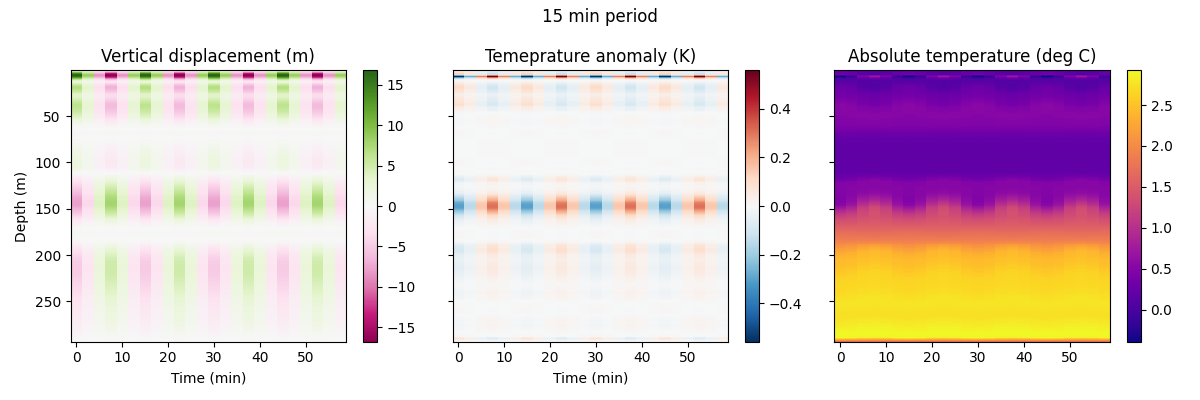

In [20]:
## Create synthetic data

# depth slice across time
dt = 150
t = np.arange(0,60*60,dt)
nt = len(t)
tt,zz = np.meshgrid(t,z)

iw = 1 # which frequency
w = ws[iw]
A = np.ones(nn)*5 # all modes get equal amplitude??
D = np.zeros(tt.shape)
dTdz = np.tile(np.gradient(T),(nt,1)).T
for n in range(nn):
    D += A[n] * np.cos(w*tt) * np.tile(W[iw,:,n]/max(W[iw,:,n]),(nt,1)).T 
DT = D * dTdz
DT_abs = DT + np.tile(T,(nt,1)).T

fig, ax = plt.subplots(1,3,sharex=True,sharey=True,figsize=(12,4))
im0 = ax[0].pcolormesh(tt/60,zz,D,cmap='PiYG')
im1 = ax[1].pcolormesh(tt/60,zz,DT,cmap='RdBu_r')
im2 = ax[2].pcolormesh(tt/60,zz,DT_abs,cmap='plasma')
ax[0].set_xlabel('Time (min)')
ax[1].set_xlabel('Time (min)')
ax[0].set_ylabel('Depth (m)')
ax[0].set_title('Vertical displacement (m)')
ax[1].set_title('Temeprature anomaly (K)')
ax[2].set_title('Absolute temperature (deg C)')
plt.colorbar(im0,ax=ax[0])
plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
ax[1].invert_yaxis()
fig.suptitle('%d min period' % (2*np.pi/w/60))
fig.tight_layout()


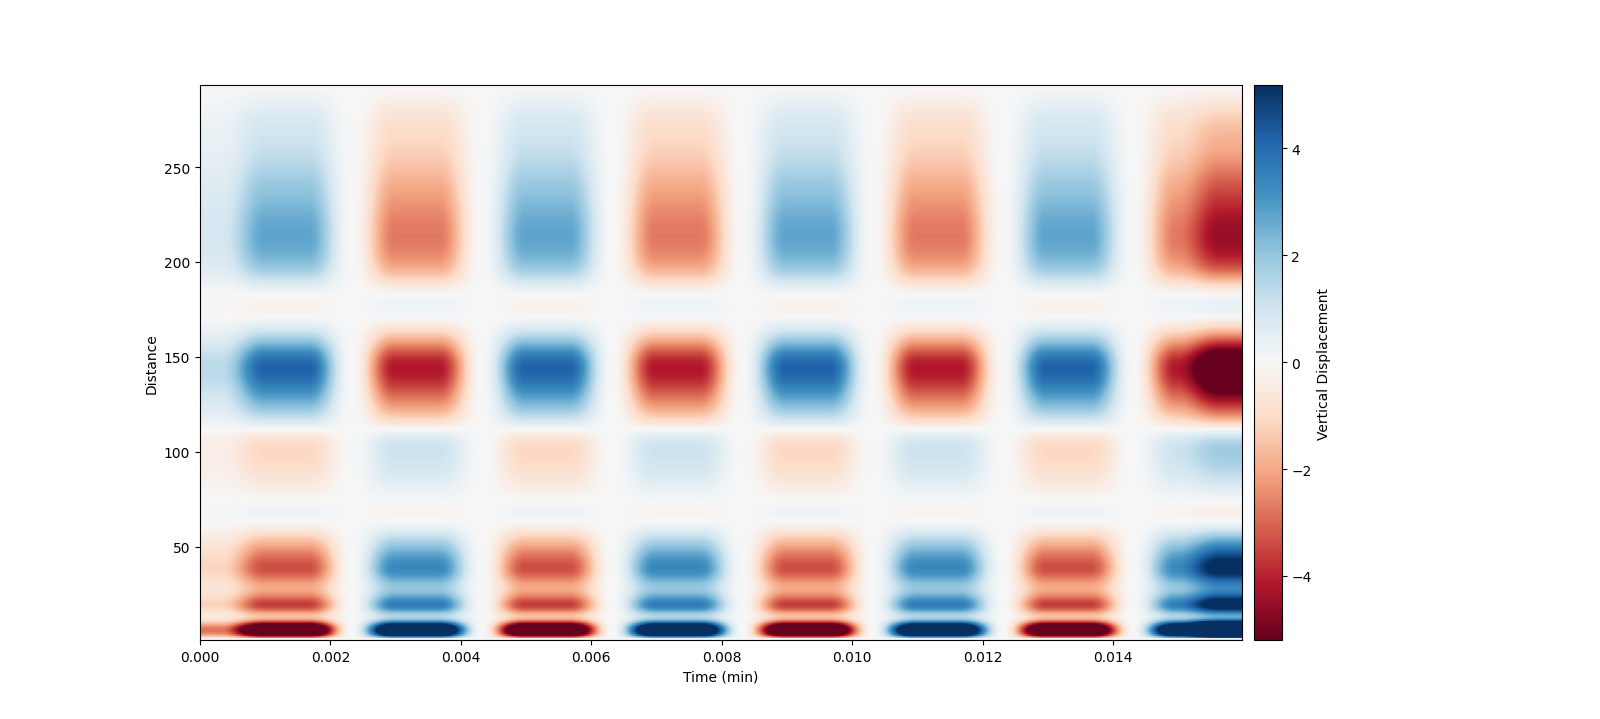

In [63]:
disps_interp = (D - np.min(D)) / (np.max(D) - np.min(D))
filtered_arr = (DT_abs - np.min(DT_abs)) / (np.max(DT_abs) - np.min(DT_abs))
plot_times_zoomed = t/60
plot_dists_zoomed = z
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = ps.SmoothedFiniteDifference(axis=1)._differentiate(disps_interp, t=dt)
dddt = ps.SmoothedFiniteDifference(axis=1)._differentiate(ddt, t=dt)
im1 = ax.imshow(ddt, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='RdBu',
            vmin=np.percentile(ddt[~np.isnan(ddt)],1),
            vmax=np.percentile(ddt[~np.isnan(ddt)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time (min)')

# plt.plot(times_flattened, depths_flattened, 'ok', label="input point", markersize=0.4)
# plt.scatter(X, Y, s=0.4)
plt.plot()
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


# Set up SINDy

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

avg_temp = np.mean(filtered_arr, axis=1)

## SINDy Stuff

## Trying with original method (not weak)

In [45]:
window_size = 50
step_size = 30 # 20
x = plot_dists_zoomed
t = plot_times_zoomed
sparsity = 1e3

Score =  -12.944127756349998
(u)' = 0.000
((du/dt))' = 101.872 1 + -397.012 uu


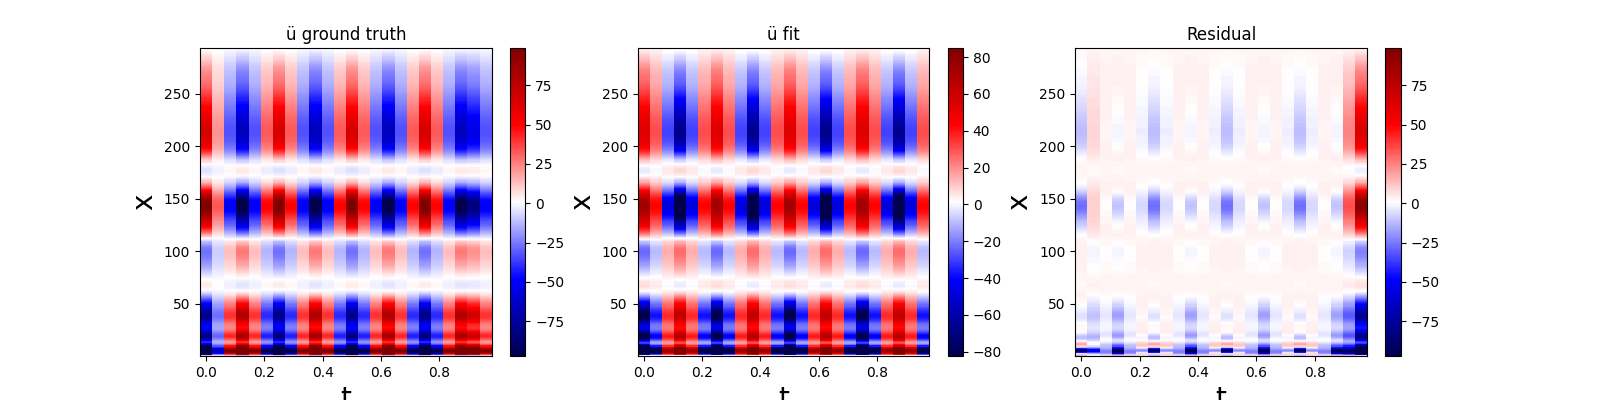

In [69]:
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = disps_interp
v_sol = ps.SmoothedFiniteDifference(axis=1)._differentiate(u_sol, t=dt)

# feature_value[:, 1] = ps.SmoothedFiniteDifference(axis=0)._differentiate(avg_temp, t=dt) 

u = np.zeros((len(x), len(t), 2))
u[:, :, 0] = u_sol
u[:, :, 1] = v_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

library_functions = [
    lambda x: x,
    lambda x: x * x,
    lambda x, y: x * y,
    lambda x, y: x * x * y,
    lambda x, y: x * y * y
]
library_function_names = [
    lambda x: x,
    lambda x: x + x,
    lambda x, y: x + y,
    lambda x, y: x + x + y,
    lambda x, y: x + y + y
]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
)

optimizer = ps.STLSQ(
    threshold= 1e3, # 8e-2
    max_iter=10000,
    normalize_columns=True,
)

feat_names = ['u', '(du/dt)']

model = ps.SINDy(feature_library=pde_lib, feature_names=feat_names, optimizer=optimizer)

model.fit(u, x_dot=u_dot, quiet=True)

# Get the coefficients
coefficients = model.coefficients()

# Get the term names
feature_names = model.get_feature_names()
score = model.score(u,t=dt)
print("Score = ", score)
model.print()

u_dot_stlsq = model.predict(u)
u_dot_test = u_dot
t_test = t

min = np.percentile(u_dot_test[~np.isnan(u_dot_test[:, :, 1]), 1],1)
max = np.percentile(u_dot_test[~np.isnan(u_dot_test[:, :, 1]), 1],99)

# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(t, x, u_dot_test[:, :, 1],
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü ground truth')
ax = plt.gca()

plt.subplot(1, 3, 2)
u_dot_stlsq = np.reshape(u_dot_stlsq[:, :, 1], (len(x), len(t_test)))
plt.pcolormesh(t_test, x, u_dot_stlsq,
            cmap='seismic', vmin=np.percentile(u_dot_test[~np.isnan(u_dot_stlsq[:, :])],1), vmax=np.percentile(u_dot_test[~np.isnan(u_dot_stlsq[:, :])],99))
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('ü fit')
ax = plt.gca()

plt.subplot(1, 3, 3)
plt.pcolormesh(t_test, x, u_dot_stlsq[:, :] - u_dot_test[:, :, 1],
            cmap='seismic', vmin=min, vmax=max)
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

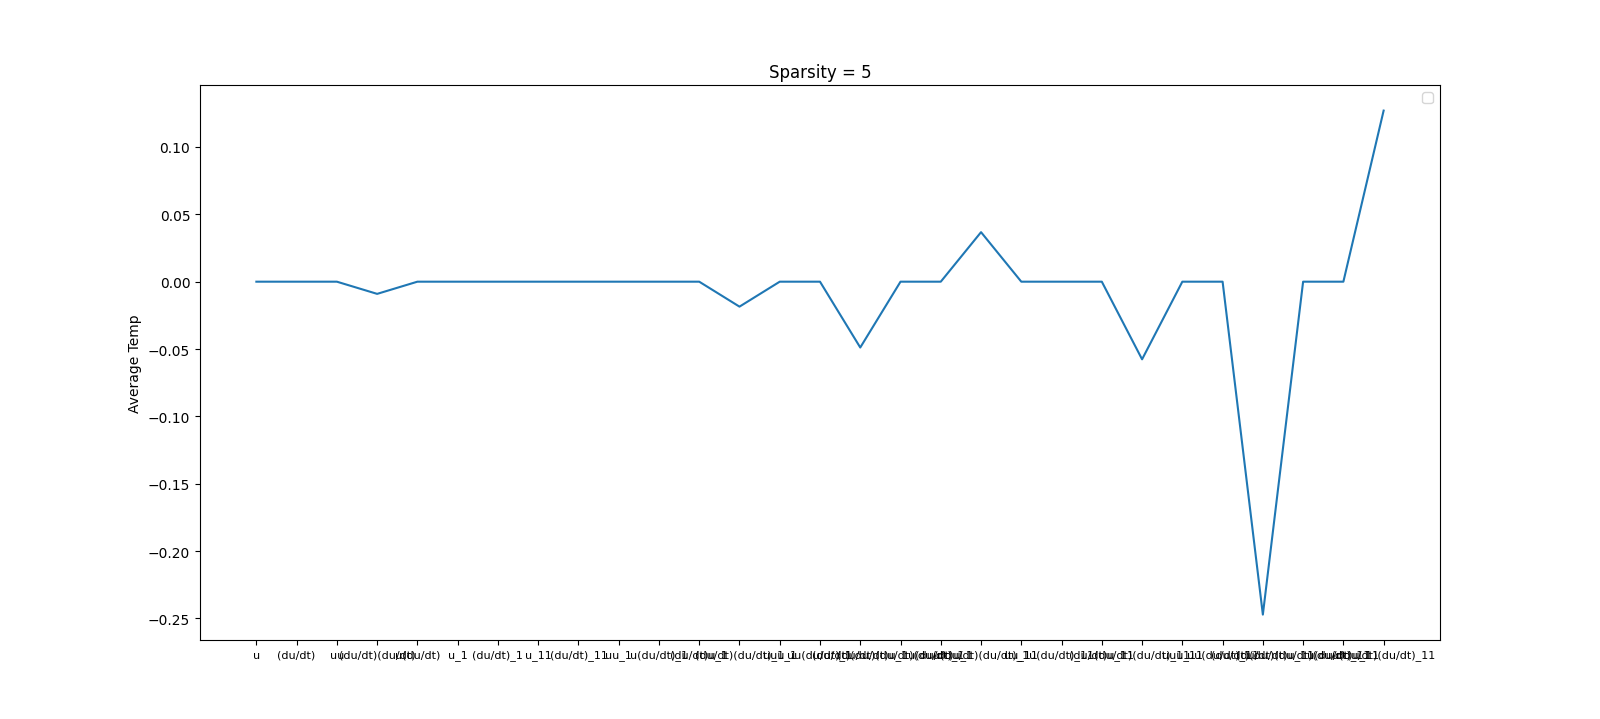

In [50]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plt.plot(feature_names, coefs)
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
plt.title("Sparsity = " + str(sparsity))
plt.xticks(fontsize=8)
# plt.xlim(segment_t[0], segment_t[-1])
# plt.ylim([-1e-1, 1e-1])
plt.ylabel("Average Temp")
plt.legend()

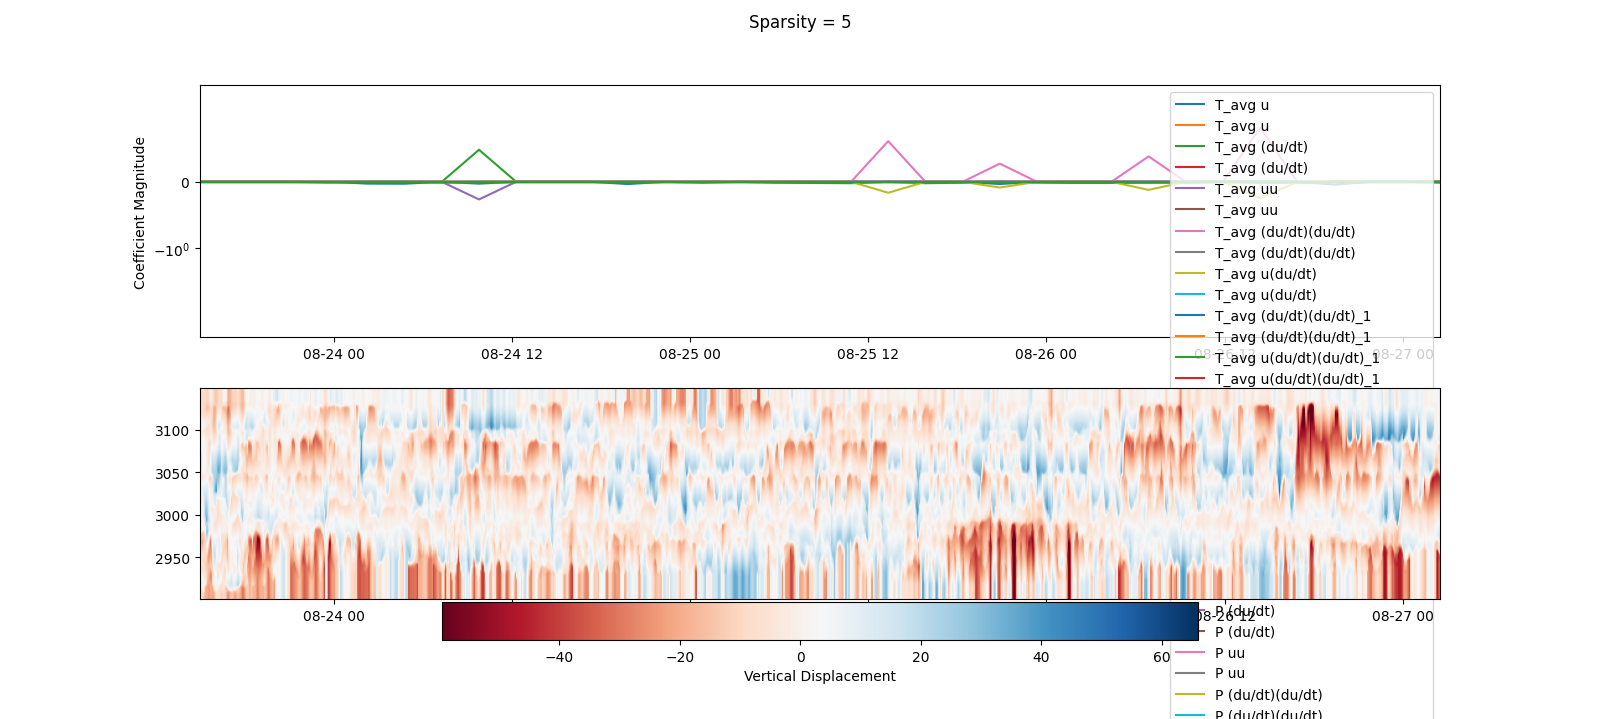

In [19]:
fig, ax = plt.subplots(2, figsize=(2.5*6.4,1.5*4.8))
for i in range(len(feature_names)): 
    if(np.mean(np.abs(coefficients[i, :])) > 0): ax[0].plot(segment_t, coefficients[i, :], 0.1, '-', label=feature_names[i])
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
fig.suptitle("Sparsity = " + str(sparsity))
# plt.xlim(segment_t[0], segment_t[-1])
ax[0].set_yscale('symlog')
ax[0].set_ylabel('Coefficient Magnitude')
ax[0].set_xlim([plot_times_zoomed[4000], plot_times_zoomed[5000]])
ax[1].set_xlim([plot_times_zoomed[4000], plot_times_zoomed[5000]])
ax[0].legend()

im1 = ax[1].imshow(disps_interp, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='RdBu',
            vmin=np.percentile(disps_interp[~np.isnan(disps_interp)],1),
            vmax=np.percentile(disps_interp[~np.isnan(disps_interp)],99),
            )
cbar = fig.colorbar(im1, pad=0.01, orientation='horizontal')
cbar.set_label('Vertical Displacement')
# ax[1].vlines(plot_times_zoomed[np.arange(0, n_segments) * window_size], plot_dists_zoomed[0], plot_dists_zoomed[-1])

## Weak formulation
This is the weak formulation included just in case I want to run it, but isn't super helpful because it doesn't perform much better than the normal SINDy on the longer-term data.

In [22]:
# Example data (replace with your actual data)
train_ind = -1
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths_interp[:] - depths_interp[0] # grid_y[0, :]
dt = t[1] - t[0]
dx = x[1] - x[0]

u_sol = disps_interp


u = np.zeros((len(x), len(t), 1))
u[:, :, 0] = u_sol
u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

ux = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=0)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=0)._differentiate(u, dx)


In [23]:
# Define PDE library that is quadratic in u, and 
# third-order in spatial derivatives of u.
spatiotemporal_grid=np.zeros((len(x),len(t),2))
spatiotemporal_grid[:,:,0]=x[:,np.newaxis]
spatiotemporal_grid[:,:,1]=t[np.newaxis,:]

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
np.random.seed(1)

In [24]:
multiindices=np.array([[0,1],[0,2],[1,0],[2,0]])
pde_lib = ps.PDELibrary(library_functions=library_functions,
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=x, temporal_grid=t,
                        include_bias=True, is_uniform=True,implicit_terms=True, multiindices=multiindices)

sindy_opt = ps.SINDyPI(
    threshold=1e-1, max_iter=1000, tol=1e-10,
    thresholder='l1', normalize_columns=False
)
model = ps.SINDy(feature_library=pde_lib, optimizer=sindy_opt)
model.fit(u, t=dt)
model.print()
# print('score', model.score(u,t=dt))

Model  0


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 0, try changing your library
  warnings.warn(


Model  1


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 1, try changing your library
  warnings.warn(


Model  2


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 2, try changing your library
  warnings.warn(


Model  3


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 3, try changing your library
  warnings.warn(


Model  4


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 4, try changing your library
  warnings.warn(


Model  5


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 5, try changing your library
  warnings.warn(


Model  6


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 6, try changing your library
  warnings.warn(


Model  7


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 7, try changing your library
  warnings.warn(


Model  8


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 8, try changing your library
  warnings.warn(


Model  9


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 9, try changing your library
  warnings.warn(


Model  10


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 10, try changing your library
  warnings.warn(


Model  11


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 11, try changing your library
  warnings.warn(


Model  12


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 12, try changing your library
  warnings.warn(


Model  13


/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 13, try changing your library
  warnings.warn(


Model  14
1 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0x0 = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0_t = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0_tt = nan 1 + nan x0 + nan x0x0 + nan x0_t + nan x0_tt + nan x0_1 + nan x0_11 + nan x0x0_t + nan x0x0x0_t + nan x0x0_tt + nan x0x0x0_tt + nan x0x0_1 + nan x0x0x0_1 + nan x0x0_11 + nan x0x0x0_11
x0_1 = nan 1 + nan 

/Users/eric/Desktop/UW_Lab_Work/for_Eric/UW_venv/lib/python3.12/site-packages/pysindy/optimizers/sindy_pi.py:201: ConvergenceWarning: Infeasible solve on iteration 14, try changing your library
  warnings.warn(


In [ ]:
lhs_actual=pde_lib.transform(u)
lhs_predict=model.predict(u)

scores=[r2_score(np.reshape(lhs_actual[:,:,ind],(np.product(lhs_actual.shape[:-1]))),np.reshape(lhs_predict[:,:,ind],(np.product(lhs_actual.shape[:-1])))) for ind in range(lhs_predict.shape[-1])]

plt.plot(scores,'bo')
plt.xlabel('model')
plt.ylabel('score')
plt.show()

order=np.argsort(scores)
for ind in np.flip(order[-5:]):
    print(pde_lib.get_feature_names()[ind] + '=' + model.equations()[ind] + ', score=' +str(scores[ind]))

ValueError: Input contains NaN.

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_86822/323179050.py:13: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Ground truth $\dot{u}$')
/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_86822/323179050.py:25: SyntaxWarning: invalid escape sequence '\d'
  plt.title('Fitted $\dot{u}$')


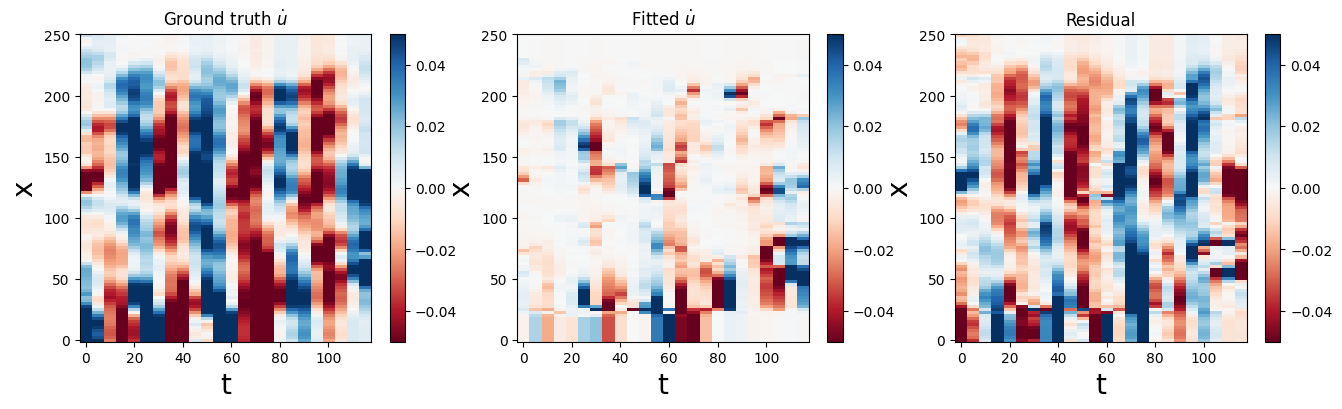

In [ ]:
u_dot_pred = model.predict(u)
model_num = 3
min = -5e-2
max = 5e-2
# Make fancy plot comparing derivative
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
# plt.pcolormesh(t_test, x, u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot[:, :, 0], shading='nearest', vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Ground truth $\dot{u}$')
ax = plt.gca()


plt.subplot(1, 3, 2)
# u_dot_stlsq = np.reshape(u_dot_stlsq, (len(x), len(t_test)))
# plt.pcolormesh(t_test, x, u_dot_stlsq, vmin=-1.5, vmax=1.5)
# u_dot_stlsq = np.reshape(u_dot_sr3, (len(x), len(t_test), 1))
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num], shading='nearest', vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Fitted $\dot{u}$')
ax = plt.gca()

plt.subplot(1, 3, 3)
# plt.pcolormesh(t_test, x, u_dot_stlsq - u_dot_test, vmin=-1.5, vmax=1.5)
plt.pcolormesh(t, x, u_dot_pred[:,:,model_num] - u_dot[:,:,0], vmin=min, vmax=max, cmap='RdBu')
plt.colorbar()
plt.xlabel('t', fontsize=20)
plt.ylabel('x', fontsize=20)
plt.title('Residual')
ax = plt.gca()

plt.show()